# Toy model

Our toy model is that we have 2 grid cells, H and T, a "real" probability $p_{\text{real}}$, and a predicted probability $p$, of events occurring, independently, in $H$.

We are interested in the distributions of our statistics, given different values of $p$ and $p_{\text{real}}$.

In [1]:
%matplotlib inline
from common import *
import lzma, pickle

The trial data will simply be pairs $(n_H, n_T)$ of counts in cells $H$ and $T$.  For each trial, we choose $n = n_H + n_T$ independently from a Poisson distribution with mean $\mu$.

In [ ]:
def make_data(trials, average_trial_size, p_real):
    trial_data = {}
    for p in p_real:
        out = []
        while len(out) < trials:
            n = np.random.poisson(average_trial_size)
            if n == 0:
                continue
            nH = np.random.binomial(n, p)
            out.append((nH, n - nH))
        trial_data[p] = out
    return trial_data

p_real = [x/10 for x in range(1,10)]

Uncomment these next two boxes to reproduce the data and save as a `pickled` file.

In [2]:
#trial_data = make_data(1000, 10, p_real)
#trial_data_50 = make_data(1000, 50, p_real)

In [148]:
#with lzma.open("toy_model_trails.pic.xz", "wb") as f:
#    pickle.dump(trial_data, f)
#    pickle.dump(trial_data_50, f)

## Get into `open_cp` data structures

In [149]:
with lzma.open("toy_model_trails.pic.xz", "rb") as f:
    trial_data = pickle.load(f)
    trial_data_50 = pickle.load(f)

In [5]:
def to_prediction(p):
    matrix = np.asarray([[p, 1-p]])
    matrix = np.ma.array(matrix, mask=[[False, False]])
    return open_cp.predictors.GridPredictionArray(10, 10, matrix)

g = to_prediction(0.3)
assert str(g) == "GridPredictionArray(offset=(0,0), size=10x10, risk intensity size=2x1)"
np.testing.assert_allclose(g.intensity_matrix, [[0.3, 0.7]])
np.testing.assert_allclose(g.intensity_matrix.mask, [[False]*2])

def to_timed_points(nH, nT):
    n = nH + nT
    xcs = np.random.random(n) * 10
    xcs[nH:] += 10
    ycs = np.random.random(n) * 10
    times = [datetime.datetime(2017,1,1) + datetime.timedelta(minutes=m) for m in range(n)]
    return open_cp.data.TimedPoints.from_coords(times, xcs, ycs)

tps = to_timed_points(2,3)
np.testing.assert_allclose(np.floor(tps.xcoords / 10), [0,0,1,1,1])
np.testing.assert_allclose(np.floor(tps.ycoords / 10), [0] * 5)

In [6]:
def process_to_scores(trial_data, p, func, min_size=1):
    data = {}
    for key in trial_data:
        out = []
        for (nH, nT) in trial_data[key]:
            tps = to_timed_points(nH, nT)
            if tps.number_data_points < min_size:
                continue
            out.append(func(to_prediction(p), tps))
        data[key] = out
    return data

In [7]:
def plot_percentiles(data, ax, **kwargs):
    """Plot on single axis the 10% through 90% percentiles in steps of 10%.
    
    :param data: Dictionary from "x axis value" to list of values.
    """
    percentiles = np.arange(0, 110, 10)
    ycs = []
    xcs = list(data)
    for x in xcs:
        ycs.append(np.percentile(data[x], percentiles, interpolation="linear"))
    ycs = np.asarray(ycs).T
    
    ax.plot(xcs, ycs[5], color="black", linestyle="-", label="50%", **kwargs)
    for i, la in zip([3,4,6,7], ["30%", "40%", "60%", "70%"]):
        ax.plot(xcs, ycs[i], color="black", linestyle="--", label=la, **kwargs)
    for i, la in zip([1,2,8,9], ["10%", "20%", "80%", "90%"]):
        ax.plot(xcs, ycs[i], color="black", linestyle=(1,(1,3)), label=la, **kwargs)

# Check cases

For the comparison methods which have a closed form, we check that our code produces the same result.

## Hit rates

Come back to this, as it's not so interesting.  If $p < 1/2$, then the hitrate is $n_T / n$ for coverages less than 50% and $1$ for coverages over 50%; and if $p>1/2$ then we get $n_H / n$ instead.

In [8]:
coverages = [x/2 for x in range(1,10)] + list(range(5,20)) + list(range(20,100,5))
hitrates = process_to_scores(trial_data, 0.2, lambda p, t : open_cp.evaluation.hit_rates(p, t, coverages))

def hitrate(nH, nT, c):
    if c < 50:
        return 0
    if c < 100:
        return nT / (nH+nT)
    return 1.0

expected = {}
for key in trial_data:
    out = [{c : hitrate(nH, nT, c) for c in coverages} for (nH, nT) in trial_data[key]]
    expected[key] = out

In [9]:
assert hitrates == expected

## Rank ordering

In [10]:
rankings = process_to_scores(trial_data, 0.2, open_cp.evaluation.ranking_score)

In [11]:
expected = {k: [ [0.5] * nH + [1] * nT for (nH, nT) in trial_data[k] ]
           for k in trial_data}

In [12]:
for k in rankings:
    for a, b in zip(rankings[k], expected[k]):
        np.testing.assert_allclose(a, b)

## Likelihood

In [13]:
likelihood = process_to_scores(trial_data, 0.2, open_cp.evaluation.likelihood)

In [14]:
p = 0.2
for k in trial_data:
    expected = []
    for nH, nT in trial_data[k]:
        expected.append((nH * np.log(p) + nT * np.log(1-p)) / (nH + nT))
    np.testing.assert_allclose(expected, likelihood[k])

## KDE

Has no simple closed form, so we'll skip at this stage.

## Scoring rules

Again, the Poisson CRPS case has no closed form.

In [15]:
brier = process_to_scores(trial_data, 0.2, open_cp.evaluation.brier_score)

In [16]:
brier[0.1][0]

(2.1301775147928973e-05, 0.99699899966655559)

In [17]:
p = 0.2
for key in trial_data:
    expected = []
    for nH, nT in trial_data[key]:
        estp = nH / (nH + nT)
        score = (p - estp)**2
        skill = (p**2 + (1-p)**2 + estp**2 + (1-estp)**2) / 2
        skill = 1 - score / skill
        expected.append( (score/100, skill) )
    np.testing.assert_allclose(expected, brier[key])

## Bayesian information

In our case, the Dirichlet prior reduces to a [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution) prior.

This still requires some tedious analysis to get close to a closed form solution, so we skip.

# Visualise

## Hit rate

The only interesting coverage level is between 50% and 100%, where we get the same answer.  Symmetric in $p$, and only $p<1/2$ or $p>1/2$ matters.  We'll choose $p<1/2$.

In [18]:
hitrates = {key : [nT / (nH+nT) for (nH, nT) in trial_data[key]]
           for key in trial_data}

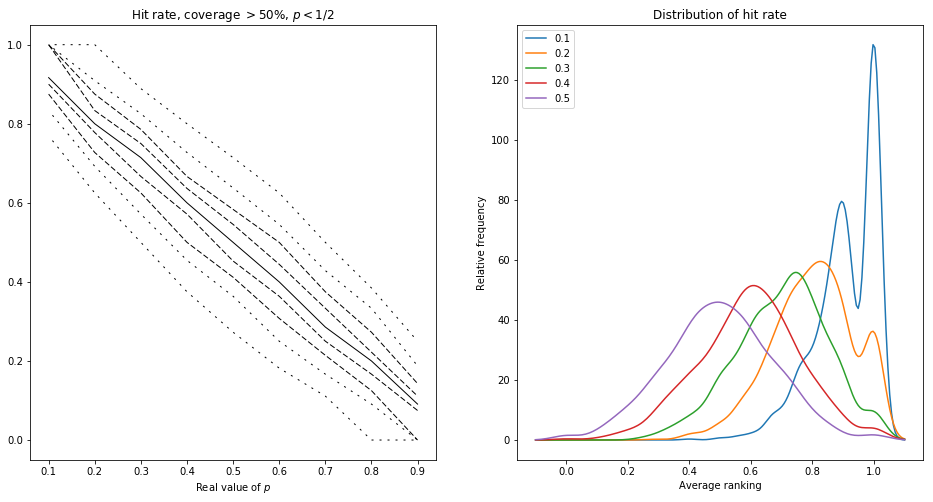

In [152]:
def plot_hitrates(hitrates):
    fig, axes = plt.subplots(ncols=2, figsize=(16,8))

    ax = axes[0]
    plot_percentiles(hitrates, ax, linewidth=1)
    ax.set(xlabel="Real value of $p$")
    ax.set_title("Hit rate, coverage $>50\%$, $p<1/2$")

    ax = axes[1]
    for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
        ker = scipy.stats.kde.gaussian_kde(hitrates[p])
        x = np.linspace(-0.1, 1.1, 200)
        ax.plot(x, ker(x)*20, label=str(p))
    ax.legend()
    ax.set(xlabel="Average ranking", ylabel="Relative frequency")
    ax.set_title("Distribution of hit rate")
    return fig

fig = plot_hitrates(hitrates)

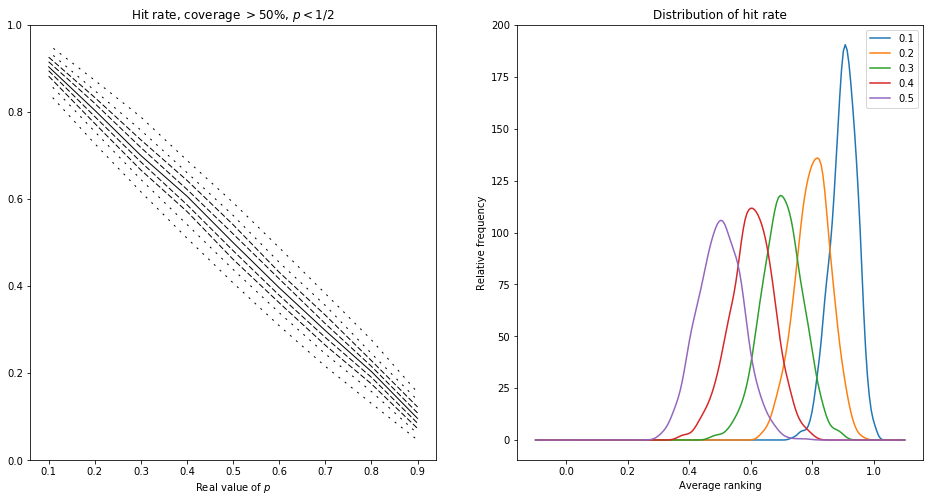

In [153]:
hitrates_50 = {key : [nT / (nH+nT) for (nH, nT) in trial_data_50[key]]
           for key in trial_data}
fig = plot_hitrates(hitrates_50)

## Ranking

If you think about it briefly, then you'll see that for 2 grid cells, this can't tell us anything hit rate doesn't.

In [154]:
p = 0.4
rankings = process_to_scores(trial_data, p, open_cp.evaluation.ranking_score)
rankings = {key : [np.mean(x) for x in v] for key, v in rankings.items()}

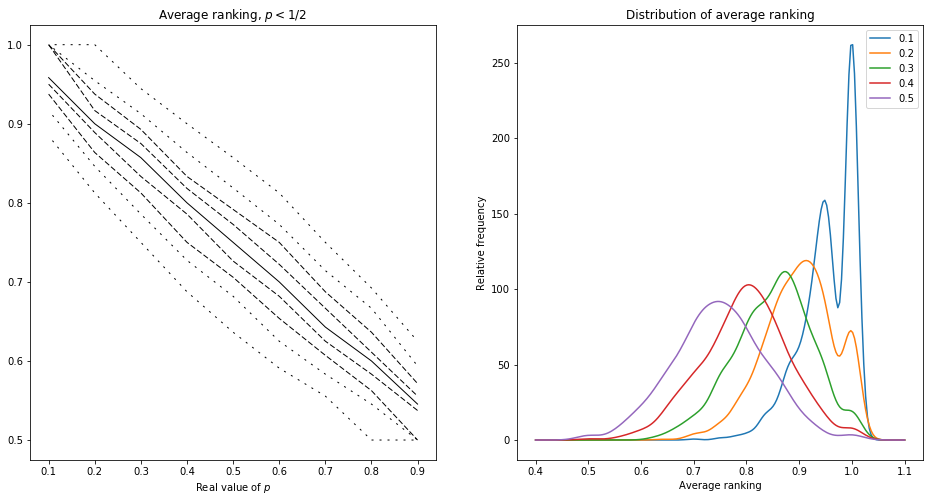

In [155]:
def plot_rankings(rankings):
    fig, axes = plt.subplots(ncols=2, figsize=(16,8))

    ax = axes[0]
    plot_percentiles(rankings, ax, linewidth=1)
    ax.set(xlabel="Real value of $p$")
    ax.set_title("Average ranking, $p<1/2$")

    ax = axes[1]
    for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
        ker = scipy.stats.kde.gaussian_kde(rankings[p])
        x = np.linspace(0.4, 1.1, 200)
        ax.plot(x, ker(x)*20, label=str(p))
    ax.legend()
    ax.set(xlabel="Average ranking", ylabel="Relative frequency")
    ax.set_title("Distribution of average ranking")
    return fig

fig = plot_rankings(rankings)

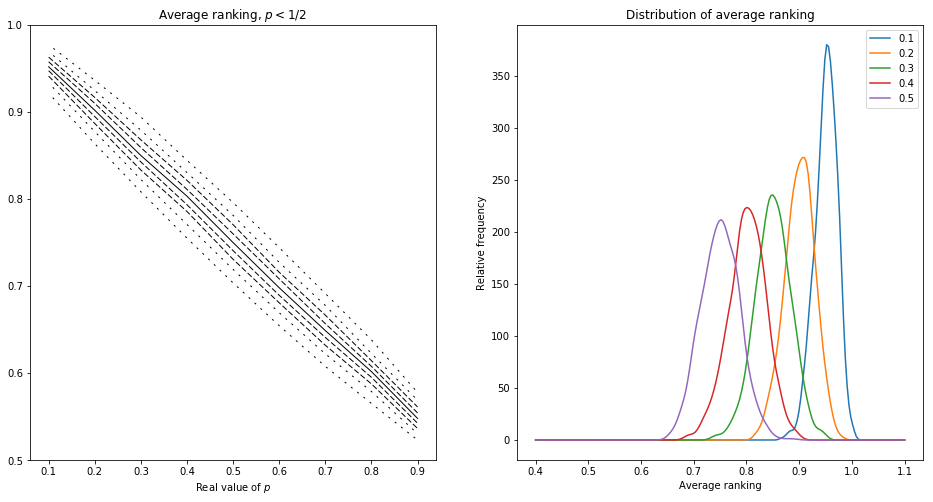

In [157]:
rankings_50 = process_to_scores(trial_data_50, p, open_cp.evaluation.ranking_score)
rankings_50 = {key : [np.mean(x) for x in v] for key, v in rankings_50.items()}
fig = plot_rankings(rankings_50)

# Likelihood

In [158]:
likelihoods = {p : process_to_scores(trial_data, p, open_cp.evaluation.likelihood)
    for p in [0.1, 0.2, 0.3, 0.4, 0.49]}

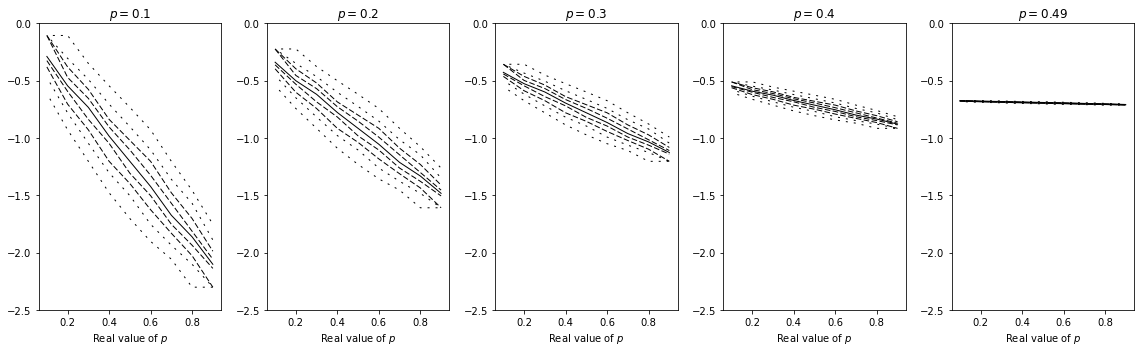

In [159]:
fig, axes = plt.subplots(ncols=5, figsize=(16,5))
for ax, (p, likelihood) in zip(axes, likelihoods.items()):
    plot_percentiles(likelihood, ax, linewidth=1)
    ax.set(xlabel="Real value of $p$")
    ax.set_title("$p={}$".format(p))
    ax.set(ylim=[-2.5,0])
fig.tight_layout()

In [160]:
fig.savefig("likehood_toy.pdf")

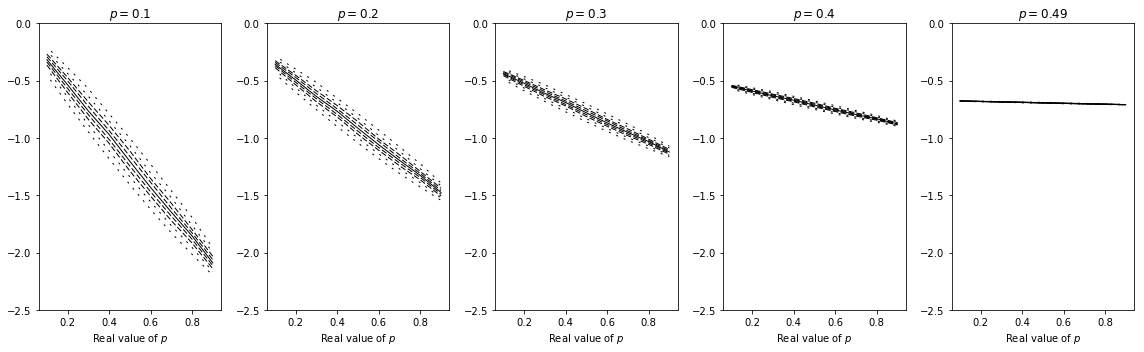

In [162]:
likelihoods_50 = {p : process_to_scores(trial_data_50, p, open_cp.evaluation.likelihood)
    for p in [0.1, 0.2, 0.3, 0.4, 0.49]}
fig, axes = plt.subplots(ncols=5, figsize=(16,5))
for ax, (p, likelihood) in zip(axes, likelihoods_50.items()):
    plot_percentiles(likelihood, ax, linewidth=1)
    ax.set(xlabel="Real value of $p$")
    ax.set_title("$p={}$".format(p))
    ax.set(ylim=[-2.5,0])
fig.tight_layout()

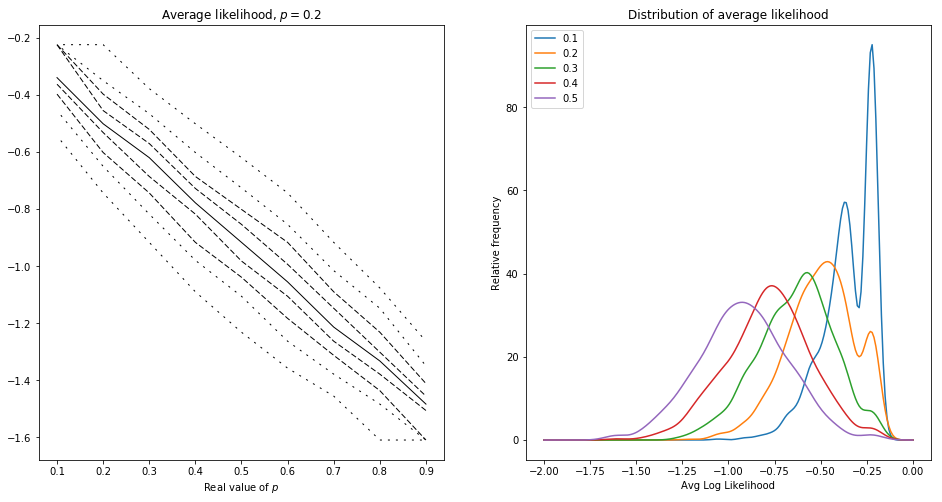

In [161]:
likelihood = likelihoods[0.2]
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
plot_percentiles(likelihood, ax, linewidth=1)
ax.set(xlabel="Real value of $p$")
ax.set_title("Average likelihood, $p=0.2$")

ax = axes[1]
for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
    ker = scipy.stats.kde.gaussian_kde(likelihood[p])
    x = np.linspace(-2, 0, 200)
    ax.plot(x, ker(x)*20, label=str(p))
ax.legend()
ax.set(xlabel="Avg Log Likelihood", ylabel="Relative frequency")
ax.set_title("Distribution of average likelihood")
None

# KDE

Plug in KDE sometimes fails, as it produces too tight a distribution.

In [26]:
grid = open_cp.data.MaskedGrid(10, 10, 0, 0, [[False, False]])
kdes = {p : process_to_scores(trial_data, p, lambda a,b :
                open_cp.evaluation.score_kde_fixed_bandwidth(a,b,grid,5), min_size=3)
        for p in [0.1, 0.2, 0.3, 0.4, 0.5]}

In [163]:
kdes_50 = {p : process_to_scores(trial_data_50, p, lambda a,b :
                open_cp.evaluation.score_kde_fixed_bandwidth(a,b,grid,5), min_size=3)
        for p in [0.1, 0.2, 0.3, 0.4, 0.5]}

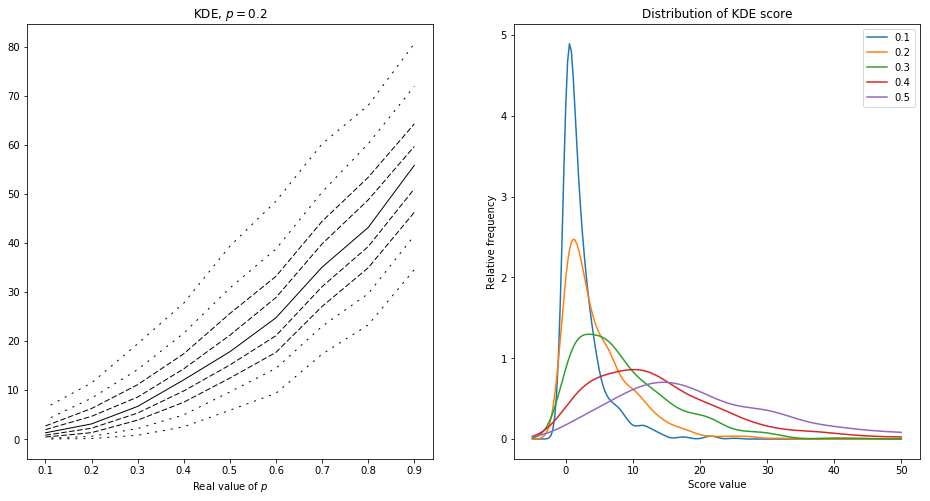

In [27]:
kde = kdes[0.2]
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
plot_percentiles(kde, ax, linewidth=1)
ax.set(xlabel="Real value of $p$")
ax.set_title("KDE, $p=0.2$")

ax = axes[1]
for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
    ker = scipy.stats.kde.gaussian_kde(kde[p])
    x = np.linspace(-5, 50, 200)
    ax.plot(x, ker(x)*20, label=str(p))
ax.legend()
ax.set(xlabel="Score value", ylabel="Relative frequency")
ax.set_title("Distribution of KDE score")
None

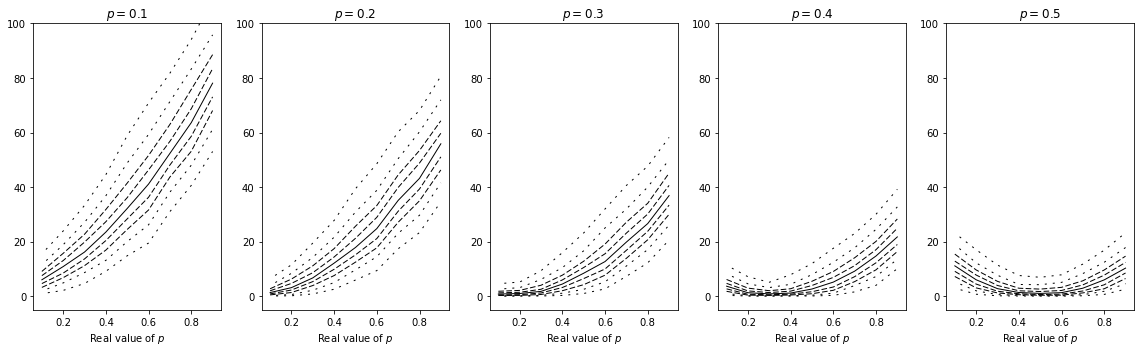

In [165]:
def plot_kde(kdes, yrange):
    fig, axes = plt.subplots(ncols=5, figsize=(16,5))
    for ax, (p, kde) in zip(axes, kdes.items()):
        plot_percentiles(kde, ax, linewidth=1)
        ax.set(xlabel="Real value of $p$")
        ax.set_title("$p={}$".format(p))
        ax.set(ylim=yrange)
    fig.tight_layout()
    return fig
fig = plot_kde(kdes, (-5, 100))

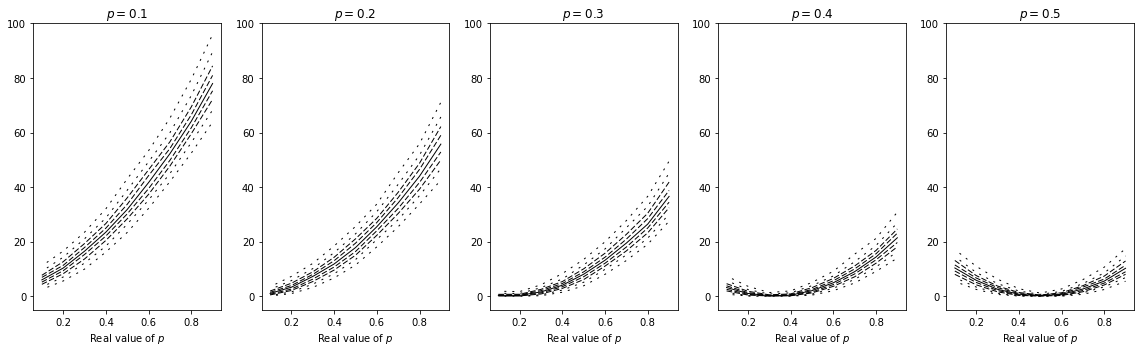

In [166]:
fig = plot_kde(kdes_50, (-5, 100))

In [29]:
grid = open_cp.data.MaskedGrid(10, 10, 0, 0, [[False, False]])
kdes2 = {p : process_to_scores(trial_data, p, lambda a,b :
        open_cp.evaluation.score_kde_fixed_bandwidth(a,b,grid,20), min_size=3)
        for p in [0.1, 0.2, 0.3, 0.4, 0.5]}

In [168]:
kdes2_50 = {p : process_to_scores(trial_data_50, p, lambda a,b :
        open_cp.evaluation.score_kde_fixed_bandwidth(a,b,grid,20), min_size=3)
        for p in [0.1, 0.2, 0.3, 0.4, 0.5]}

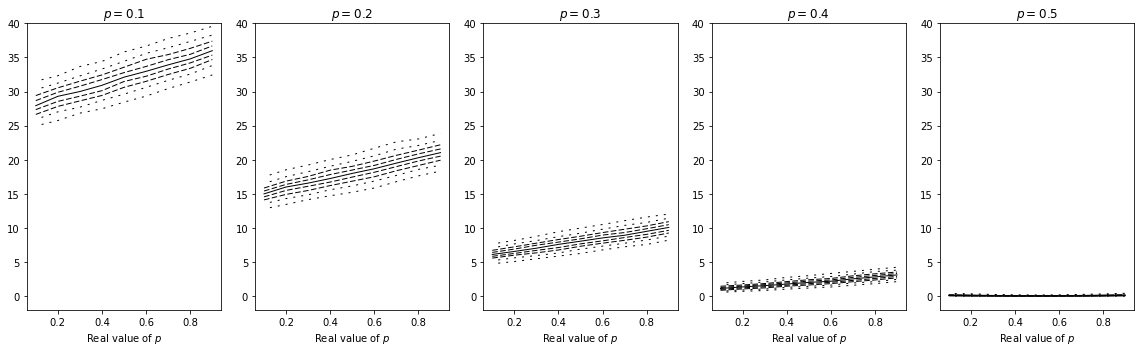

In [167]:
fig = plot_kde(kdes2, (-2, 40))

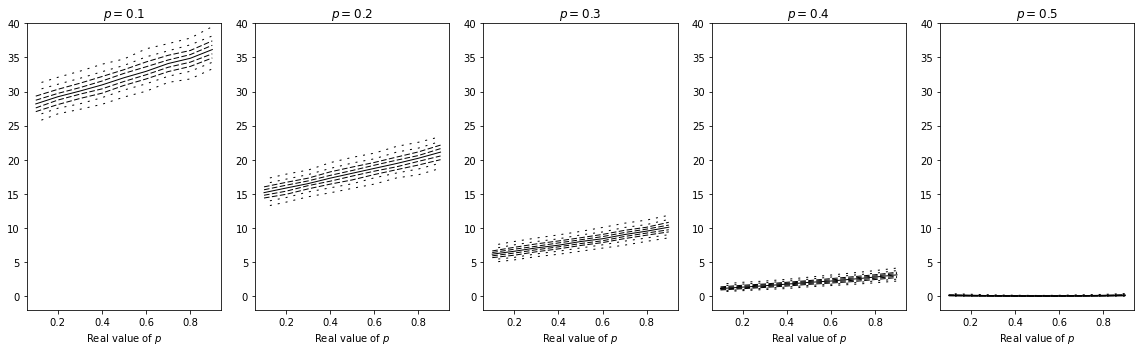

In [169]:
fig = plot_kde(kdes2_50, (-2, 40))

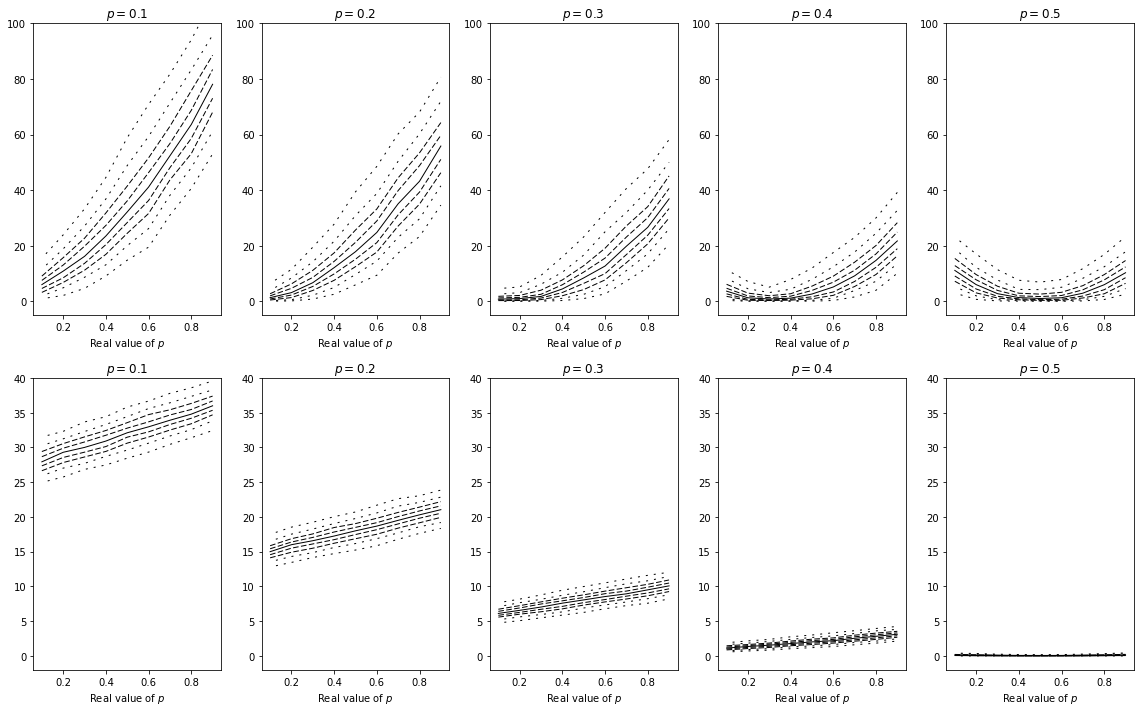

In [31]:
fig, axes_rows = plt.subplots(nrows=2, ncols=5, figsize=(16,10))
for axes, cont in zip(axes_rows, [kdes, kdes2]):
    for ax, (p, kde) in zip(axes, cont.items()):
        plot_percentiles(kde, ax, linewidth=1)
        ax.set(xlabel="Real value of $p$")
        ax.set_title("$p={}$".format(p))
for ax in axes_rows[0]:
    ax.set(ylim=[-5,100])
for ax in axes_rows[1]:
    ax.set(ylim=[-2,40])
fig.tight_layout()

In [32]:
fig.savefig("kde_toy.pdf")

## Brier

In [35]:
briers = {p:process_to_scores(trial_data, p, open_cp.evaluation.brier_score) for p in [0.1, 0.2, 0.3, 0.4, 0.5]}

In [170]:
briers_50 = {p:process_to_scores(trial_data_50, p, open_cp.evaluation.brier_score) for p in [0.1, 0.2, 0.3, 0.4, 0.5]}

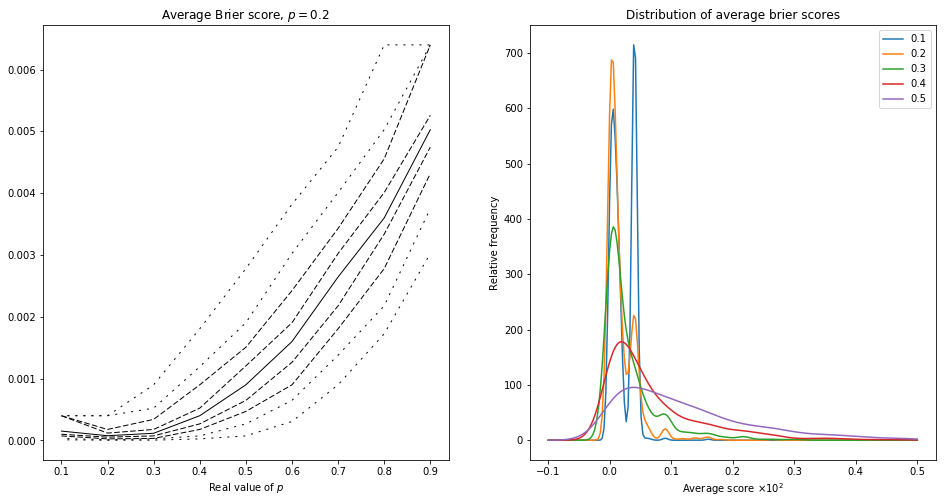

In [171]:
brier = briers[0.2]
score = {k : [x[0] for x in v] for k,v in brier.items()}
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
plot_percentiles(score, ax, linewidth=1)
ax.set(xlabel="Real value of $p$")
ax.set_title("Average Brier score, $p=0.2$")

ax = axes[1]
for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
    ker = scipy.stats.kde.gaussian_kde(np.asarray(score[p]) * 100)
    x = np.linspace(-0.1, 0.5, 200)
    ax.plot(x, ker(x)*20, label=str(p))
ax.legend()
ax.set(xlabel="Average score $\\times 10^2$", ylabel="Relative frequency")
ax.set_title("Distribution of average brier scores")
None

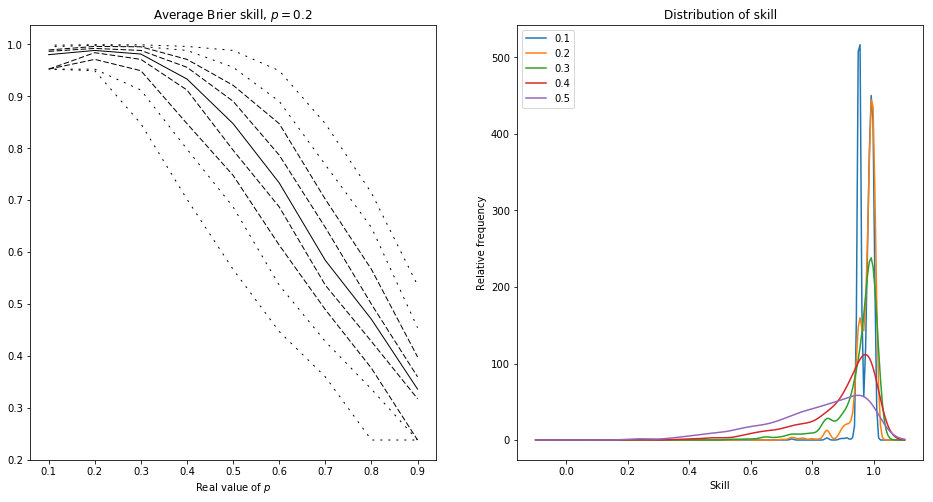

In [172]:
brier = briers[0.2]
skill = {k : [x[1] for x in v] for k,v in brier.items()}
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
plot_percentiles(skill, ax, linewidth=1)
ax.set(xlabel="Real value of $p$")
ax.set_title("Average Brier skill, $p=0.2$")

ax = axes[1]
for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
    ker = scipy.stats.kde.gaussian_kde(np.asarray(skill[p]))
    x = np.linspace(-0.1, 1.1, 200)
    ax.plot(x, ker(x)*20, label=str(p))
ax.legend()
ax.set(xlabel="Skill", ylabel="Relative frequency")
ax.set_title("Distribution of skill")
None

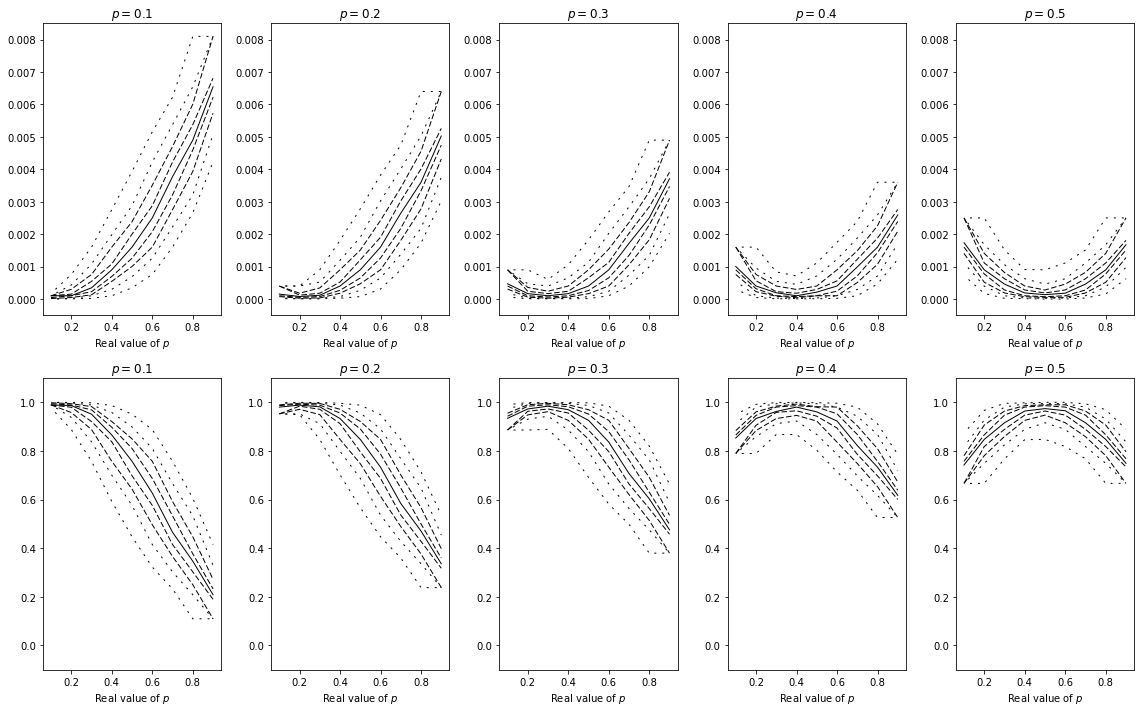

In [176]:
def plot_brier_both(briers):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,10))
    for ax, (p, brier) in zip(axes[0], briers.items()):
        data = {k:[x[0] for x in v] for k,v in brier.items()}
        plot_percentiles(data, ax, linewidth=1)
        ax.set(xlabel="Real value of $p$")
        ax.set_title("KDE, $p=0.2$")
        ax.set_title("$p={}$".format(p))
        ax.set(ylim=[-0.0005,0.0085])
    for ax, (p, brier) in zip(axes[1], briers.items()):
        data = {k:[x[1] for x in v] for k,v in brier.items()}
        plot_percentiles(data, ax, linewidth=1)
        ax.set(xlabel="Real value of $p$")
        ax.set_title("KDE, $p=0.2$")
        ax.set_title("$p={}$".format(p))
        ax.set(ylim=[-0.1, 1.1])
    fig.tight_layout()
    return fig

fig = plot_brier_both(briers)

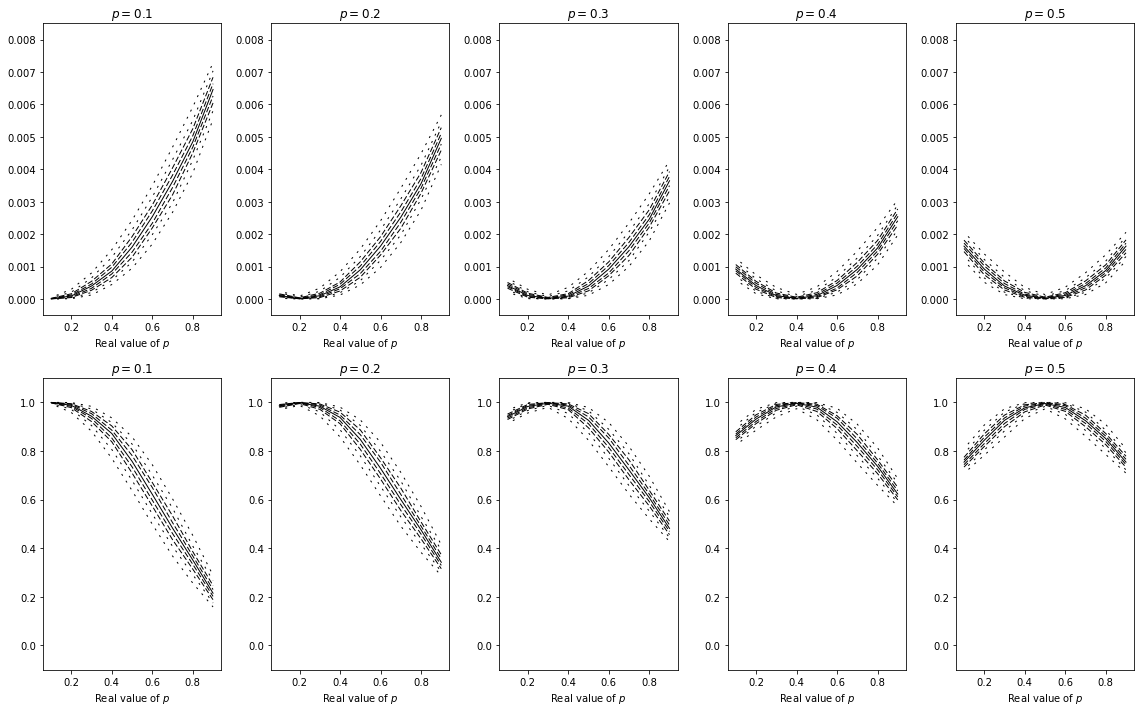

In [177]:
fig = plot_brier_both(briers_50)

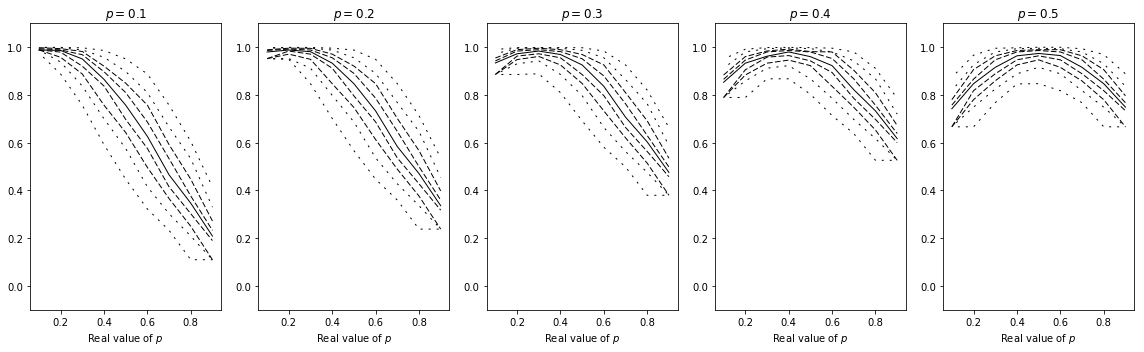

In [41]:
fig, axes = plt.subplots(ncols=5, figsize=(16,5))
for ax, (p, brier) in zip(axes, briers.items()):
    data = {k:[x[1] for x in v] for k,v in brier.items()}
    plot_percentiles(data, ax, linewidth=1)
    ax.set(xlabel="Real value of $p$")
    ax.set_title("KDE, $p=0.2$")
    ax.set_title("$p={}$".format(p))
    ax.set(ylim=[-0.1, 1.1])
fig.tight_layout()

In [42]:
fig.savefig("brier_skill_toy.pdf")

In [43]:
brier_pos = {p : process_to_scores(trial_data, p, open_cp.evaluation.poisson_crps_score)
             for p in [0.1, 0.2, 0.3, 0.4, 0.5]}

In [180]:
brier_pos_50 = {p : process_to_scores(trial_data_50, p, open_cp.evaluation.poisson_crps_score)
             for p in [0.1, 0.2, 0.3, 0.4, 0.5]}

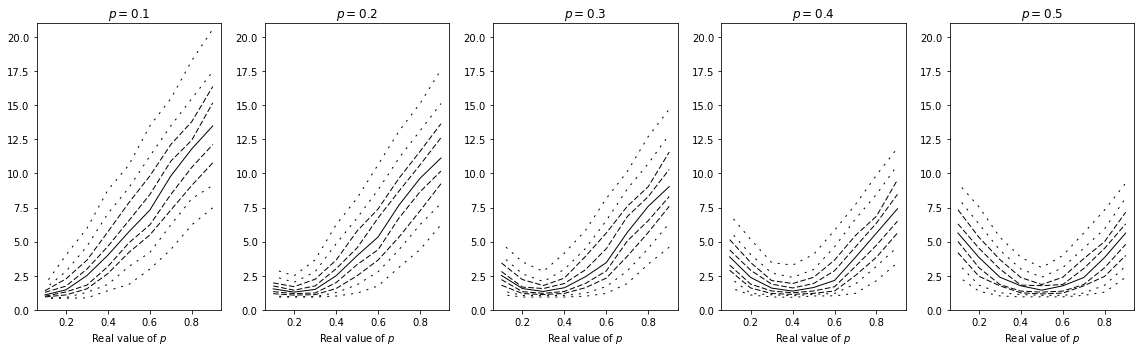

In [44]:
fig, axes = plt.subplots(ncols=5, figsize=(16,5))
for ax, (p, brier) in zip(axes, brier_pos.items()):
    plot_percentiles(brier, ax, linewidth=1)
    ax.set(xlabel="Real value of $p$")
    ax.set_title("KDE, $p=0.2$")
    ax.set_title("$p={}$".format(p))
    ax.set(ylim=[0, 21])
fig.tight_layout()

In [45]:
fig.savefig("brier_poisson_toy.pdf")

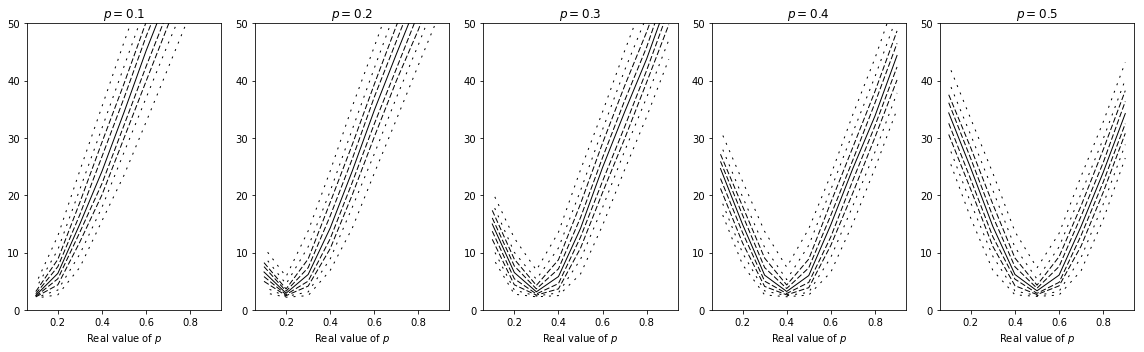

In [186]:
fig, axes = plt.subplots(ncols=5, figsize=(16,5))
for ax, (p, brier) in zip(axes, brier_pos_50.items()):
    plot_percentiles(brier, ax, linewidth=1)
    ax.set(xlabel="Real value of $p$")
    ax.set_title("KDE, $p=0.2$")
    ax.set_title("$p={}$".format(p))
    ax.set(ylim=[0, 50])
fig.tight_layout()

In [187]:
fig.savefig("brier_poisson1_toy.pdf")

## Bayesian information ideas

In [65]:
def plot_dir_prior(trial_data, bias, yrange):
    dirichlets = {p : process_to_scores(trial_data, p, lambda p,t :
                        open_cp.evaluation.bayesian_dirichlet_prior(p,t,bias=bias))
                          for p in [0.1, 0.2, 0.3, 0.4, 0.5]}
    fig, axes = plt.subplots(ncols=5, figsize=(16,5))
    for ax, (p, data) in zip(axes, dirichlets.items()):
        plot_percentiles(data, ax, linewidth=1)
        ax.set(xlabel="Real value of $p$")
        ax.set_title("$p={}$".format(p))
        ax.set(ylim=[0, yrange])
    fig.tight_layout()
    return fig

In [69]:
def plot_bpred(trial_data, bias, yrange):
    dirichlets = {p : process_to_scores(trial_data, p, lambda p,t :
                        open_cp.evaluation.bayesian_predictive(p,t,bias=bias))
                          for p in [0.1, 0.2, 0.3, 0.4, 0.5]}
    fig, axes = plt.subplots(ncols=5, figsize=(16,5))
    for ax, (p, data) in zip(axes, dirichlets.items()):
        plot_percentiles(data, ax, linewidth=1)
        ax.set(xlabel="Real value of $p$")
        ax.set_title("$p={}$".format(p))
        ax.set(ylim=[0, yrange])
    fig.tight_layout()
    return fig

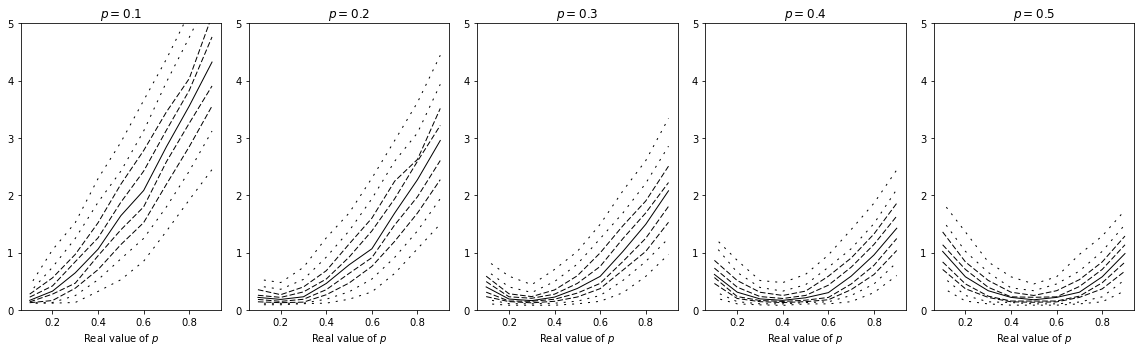

In [107]:
fig = plot_dir_prior(trial_data, 10, 5)

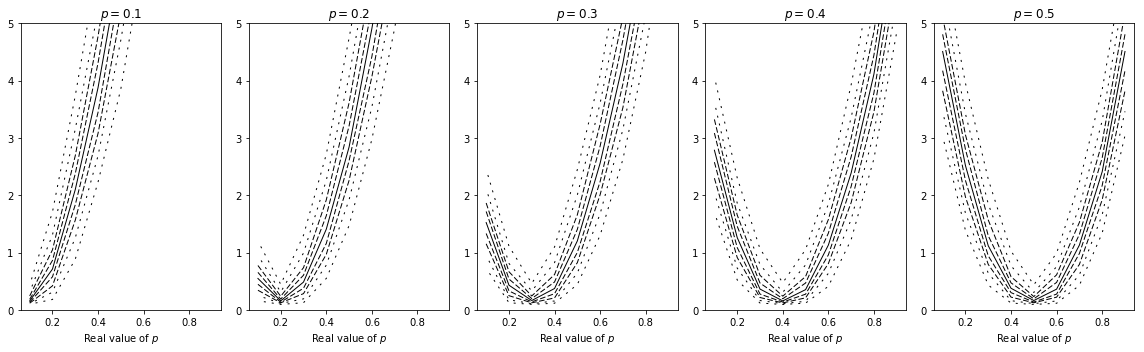

In [118]:
fig = plot_dir_prior(trial_data_50, 50, 5)

In [133]:
dirichlets = {p : process_to_scores(trial_data, p, lambda p,t :
                    open_cp.evaluation.bayesian_dirichlet_prior(p,t,bias=10))
                      for p in [0.1, 0.2, 0.3, 0.4, 0.5]}
dirichlets_50 = {p : process_to_scores(trial_data_50, p, lambda p,t :
                    open_cp.evaluation.bayesian_dirichlet_prior(p,t,bias=50))
                      for p in [0.1, 0.2, 0.3, 0.4, 0.5]}

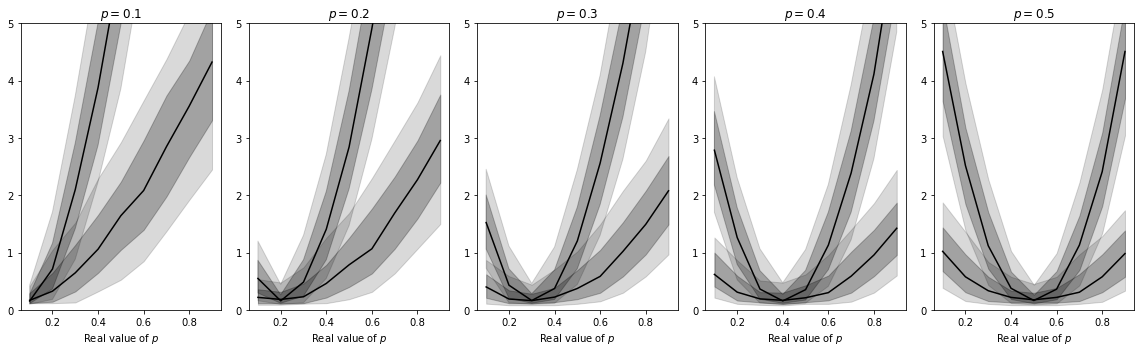

In [143]:
def plot_dir_regions(dirichlets, dirichlets_50, yrange=5):
    fig, axes = plt.subplots(ncols=5, figsize=(16,5))
    for ax, (p, data10), (_, data50) in zip(axes, dirichlets.items(), dirichlets_50.items()):
        for data in [data10, data50]:
            ycs = []
            xcs = list(data)
            for x in xcs:
                ycs.append(np.percentile(data[x], [10,25,50,75,90], interpolation="linear"))
            ycs = np.asarray(ycs).T

            ax.plot(xcs, ycs[2], color="black", linestyle="-", label="50%")
            ax.fill_between(xcs, ycs[1], ycs[3], color="black", alpha=0.25)
            ax.fill_between(xcs, ycs[0], ycs[4], color="black", alpha=0.15)

            ax.set(xlabel="Real value of $p$")
            ax.set_title("$p={}$".format(p))
            ax.set(ylim=[0, yrange])
    fig.tight_layout()
    return fig
    
fig = plot_dir_regions(dirichlets, dirichlets_50)

In [144]:
fig.savefig("info_dir_toy.pdf")

In [135]:
dirichletsp = {p : process_to_scores(trial_data, p, lambda p,t :
                    open_cp.evaluation.bayesian_predictive(p,t,bias=10))
                      for p in [0.1, 0.2, 0.3, 0.4, 0.5]}
dirichletsp_50 = {p : process_to_scores(trial_data_50, p, lambda p,t :
                    open_cp.evaluation.bayesian_predictive(p,t,bias=50))
                      for p in [0.1, 0.2, 0.3, 0.4, 0.5]}

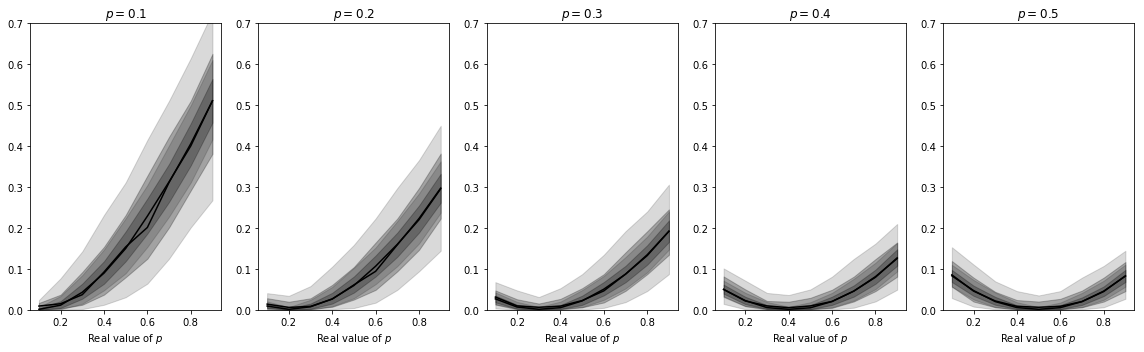

In [145]:
fig = plot_dir_regions(dirichletsp, dirichletsp_50, 0.7)

In [146]:
fig.savefig("info_dirp_toy.pdf")

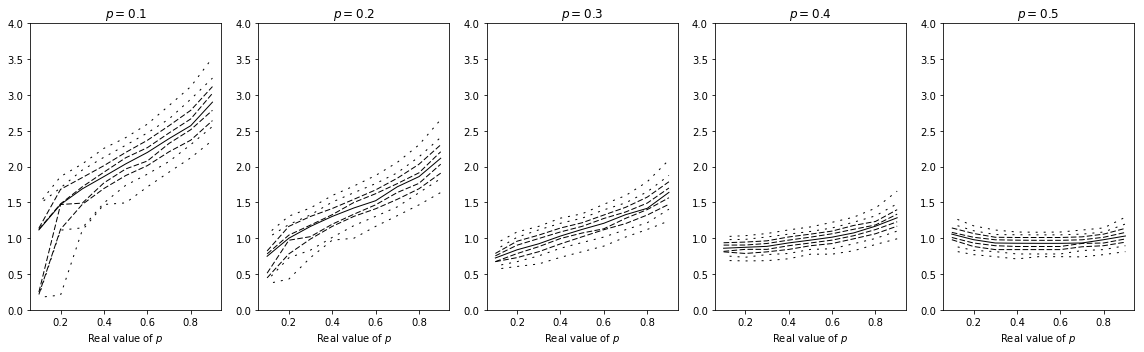

In [192]:
fig = plot_dir_prior(trial_data, 1, 4)

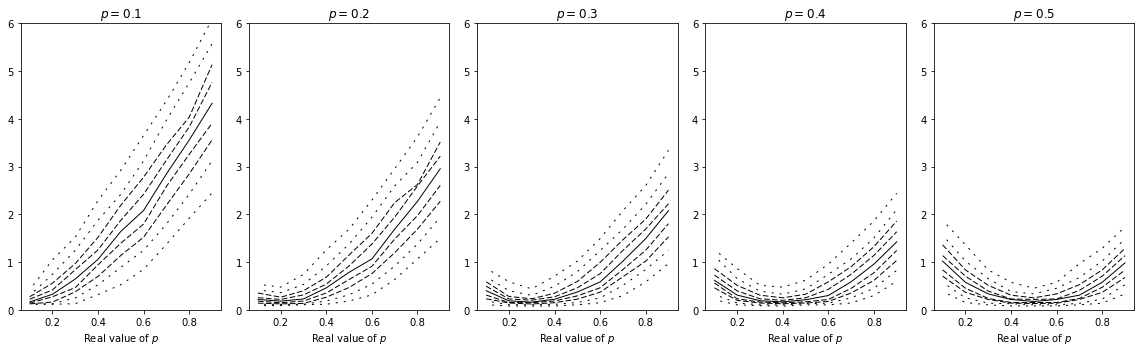

In [189]:
fig = plot_dir_prior(trial_data, 10, 6)

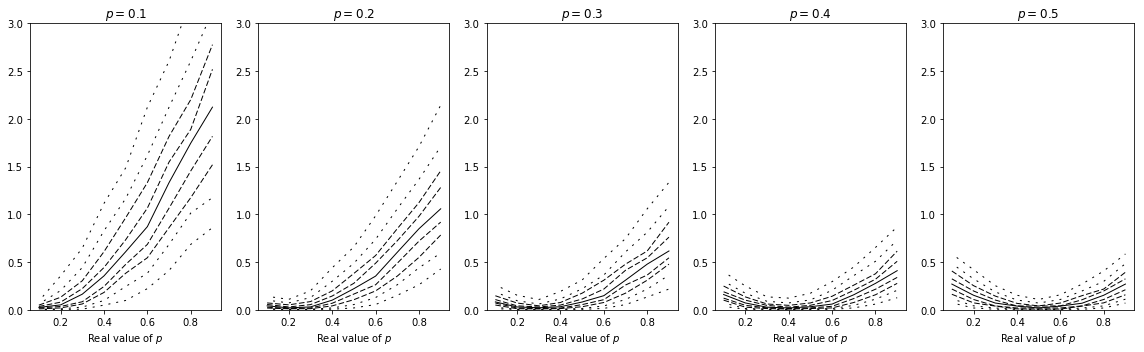

In [194]:
fig = plot_dir_prior(trial_data, 100, 3)

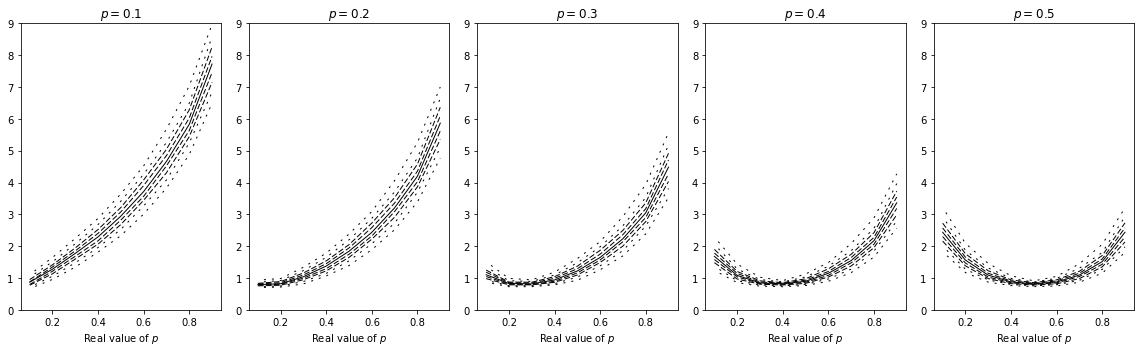

In [201]:
fig = plot_dir_prior(trial_data_50, 5, 9)

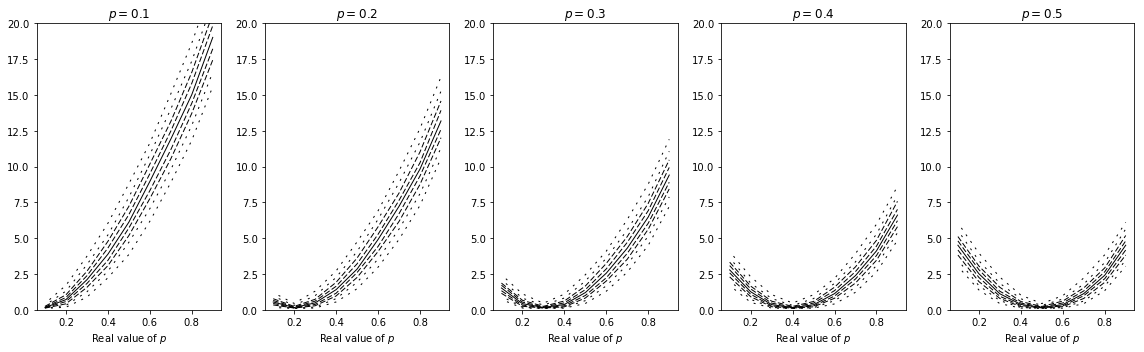

In [203]:
fig = plot_dir_prior(trial_data_50, 50, 20)

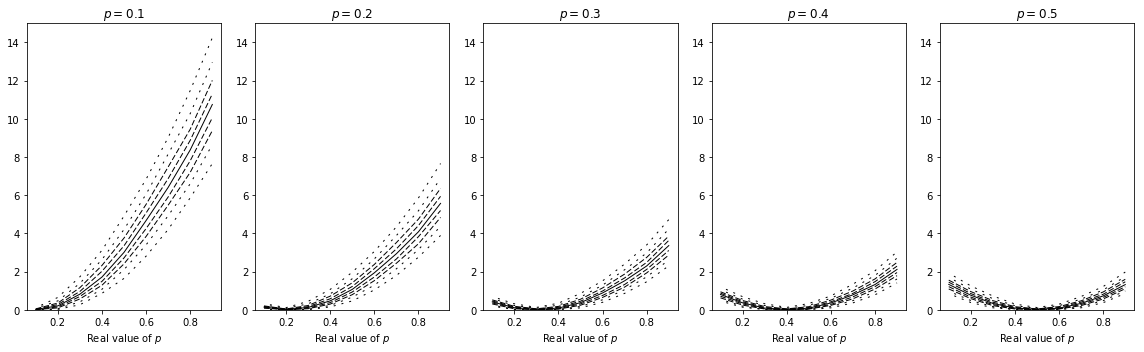

In [202]:
fig = plot_dir_prior(trial_data_50, 500, 15)

In [ ]:
fig = plot_bpred(trial_data, 1, 2)